## 모듈 정리

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import os, re

## 데이터 불러오기

In [2]:
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 194513


,eng,fra,cc
29412,I feel so helpless.,Je me sens tellement impuissante.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
45178,Tom became indignant.,Tom s'est indigné.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
73398,That's a very good point.,C'est un excellent argument.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
194353,Cats are like girls. If they talk to you it's ...,Les chats sont comme les filles. S'ils vous pa...,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
118908,We haven't seen Tom in a while.,Nous n'avons pas vu Tom depuis un bout de temps.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...


In [3]:
lines = lines[['eng', 'fra']][:33000] # 33000개 샘플 사용
lines.sample(5)

,eng,fra
22609,Crime doesn't pay.,Le crime ne paie pas.
4459,Be objective.,Sois objective.
28673,Give me your phone.,Donnez-moi votre téléphone !
5790,Sweet dreams!,Faites de beaux rêves !
8138,Let Tom leave.,Laissez Tom partir.


## 전처리 함수 
- 대문자 -> 소문자
- 구두점 분리

In [4]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

this is sample sentence .


## 영어 전처리

In [5]:
# 여기에 정제된 문장을 모을겁니다
eng = []

for sentence in lines.eng:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    eng.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
eng[:10]

['go .',
 'go .',
 'go .',
 'hi .',
 'hi .',
 'run !',
 'run !',
 'run !',
 'run !',
 'run !']

## 프랑스어 전처리

In [6]:
# 여기에 정제된 문장을 모을겁니다
fra = []

for sentence in lines.fra:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    fra.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
fra[:10]

['va !',
 'marche .',
 'bouge !',
 'salut !',
 'salut .',
 'cours !',
 'courez !',
 'prenez vos jambes vos cous !',
 'file !',
 'filez !']

## 프랑스어 시작, 종료 토큰 추가

In [7]:
# 시작 토큰과 종료 토큰 추가
sos_token = "''"
eos_token = "'"
lines.fra = lines.fra.apply(lambda x : "'' "+ x + " '")
print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 33000


,eng,fra
25325,Please be serious.,"'' Soyez sérieuse, je vous prie ! '"
14419,I want you back.,'' Je veux que vous soyez revenues. '
11311,Let me explain.,'' Laisse-moi expliquer. '
23353,How is everything?,'' Comment ça va ? '
26380,Tom is a bachelor.,'' Thomas est célibataire. '


## 영어 단어단위 토큰화

In [8]:
eng_tokenizer = Tokenizer(char_level =False)   # 문자 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(lines.eng)               # 50000개의 행을 가진 eng의 각 행에 토큰화를 수행
# print(eng_tokenizer.word_index)
input_text = eng_tokenizer.texts_to_sequences(lines.eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]

[[23], [23], [23]]

## 프랑스어 단어단위 토큰화

In [9]:
fra_tokenizer = Tokenizer()   # 문자 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(lines.fra)                 # 50000개의 행을 가진 fra의 각 행에 토큰화를 수행
# print(fra_tokenizer.word_index)
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[1, 60, 2], [1, 370, 2], [1, 731, 2]]

## 단어장 크기, 시퀀스 길이 확인

In [10]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4797
프랑스어 단어장의 크기 : 10018
영어 시퀀스의 최대 길이 6
프랑스어 시퀀스의 최대 길이 14


## 시작,종료토큰 확인

In [11]:
fra_tokenizer.word_index["''"],fra_tokenizer.word_index["'"]

(1, 2)

## 디코더 토큰 제거

In [12]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text]

## 제거된 데이터 확인
- 인풋은 시작 토큰 제거
- 타겟은 종료 토큰 제거

In [13]:
decoder_input[:3], decoder_target[:3]

([[60, 2], [370, 2], [731, 2]], [[1, 60], [1, 370], [1, 731]])

## 패딩

In [14]:
# 패딩
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 6)
프랑스어 입력데이터의 크기(shape) : (33000, 14)
프랑스어 출력데이터의 크기(shape) : (33000, 14)


## 패딩 확인

In [15]:
print(encoder_input[0])

[23  0  0  0  0  0]


## 검증셋 분리

In [16]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (33000, 6)
프랑스어 학습 입력데이터의 크기(shape) : (33000, 14)
프랑스어 학습 출력데이터의 크기(shape) : (33000, 14)


## 모델 훈련

In [17]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

## 인코더 설계

In [18]:
# 인코더에서 사용할 임베딩 층 사용 예시
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(eng_vocab_size, 256)(encoder_inputs)
encoder_lstm = LSTM(units = 256, return_state = True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장.
encoder_states = [state_h, state_c]

## 학습 디코더 설계

In [19]:
# 입력 텐서 생성.
decoder_inputs = Input(shape=(None,))
dec_emb =  Embedding(fra_vocab_size, 256)(decoder_inputs)
# hidden size가 256인 인코더의 LSTM 셀 생성
decoder_lstm = LSTM(units = 256, return_sequences = True, return_state=True)
# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(dec_emb, initial_state = encoder_states)

## 출력층 설계

In [20]:
# 출력층 설계
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

## 모델 설계

In [21]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    1228032     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    2564608     input_2[0][0]                    
______________________________________________________________________________________________

## 모델 학습

In [22]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

Epoch 1/50
235/235 [==============================] - 30s 22ms/step - loss: 1.8467 - val_loss: 1.6014
Epoch 2/50
235/235 [==============================] - 4s 18ms/step - loss: 1.0444 - val_loss: 1.0653
Epoch 3/50
235/235 [==============================] - 4s 18ms/step - loss: 0.7410 - val_loss: 0.8558
Epoch 4/50
235/235 [==============================] - 4s 19ms/step - loss: 0.5901 - val_loss: 0.7300
Epoch 5/50
235/235 [==============================] - 4s 19ms/step - loss: 0.4901 - val_loss: 0.6370
Epoch 6/50
235/235 [==============================] - 4s 19ms/step - loss: 0.4198 - val_loss: 0.5824
Epoch 7/50
235/235 [==============================] - 4s 19ms/step - loss: 0.3601 - val_loss: 0.5361
Epoch 8/50
235/235 [==============================] - 4s 19ms/step - loss: 0.3141 - val_loss: 0.5076
Epoch 9/50
235/235 [==============================] - 4s 19ms/step - loss: 0.2812 - val_loss: 0.4832
Epoch 10/50
235/235 [==============================] - 4s 19ms/step - loss: 0.2515 - val_l

## loss 그래프 출력

dict_keys(['loss', 'val_loss'])


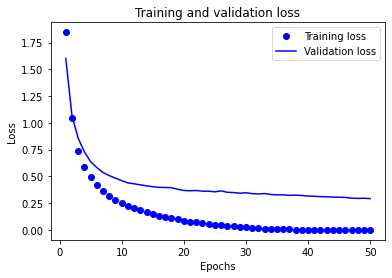

In [27]:
import matplotlib.pyplot as plt
# 그래프
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 테스트

In [28]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         1228032   
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 525312    
Total params: 1,753,344
Trainable params: 1,753,344
Non-trainable params: 0
_________________________________________________________________


## 테스트 디코더 설계

In [29]:
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(256,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs, state_h, state_c = decoder_lstm(dec_emb, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states = [state_h, state_c]

In [30]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    2564608     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

## 사전 준비

In [31]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

## 번역 함수

In [32]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = fra2idx["''"]

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char + ' '

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == "'" or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

## 문장 생성 확인

In [33]:
import numpy as np
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][3:len(lines.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[3:len(decoded_sentence)]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: Hi.
정답 문장: Salut ! 
번역기가 번역한 문장: c'est simplement atroce 
-----------------------------------
입력 문장: Hello!
정답 문장: Salut ! 
번역기가 번역한 문장: re savez grouille 
-----------------------------------
입력 문장: Hop in.
정답 문장: Montez. 
번역기가 번역한 문장: enfourchez confectionné 
-----------------------------------
입력 문장: Help me!
정답 문장: Aide-moi ! 
번역기가 번역한 문장: pourquoi l'ai 
-----------------------------------
입력 문장: Humor Tom.
정답 문장: Mettez Tom de bonne humeur. 
번역기가 번역한 문장: enfourchez pendant 


## 회고

### 학습진행 흐름 정리
1. 데이터 불러오기 (영어,프랑스어 라벨링 된 데이터)

2. 데이터 전처리 하기 (구두점 분리, 소문자 변환)

3. 시작,종료토큰 추가 및 분리 (프랑스어 디코더 설계를 위해서)

4. 패딩 

5. 검증셋 분리

6. 인코더 설계(input :영어 , output : hidden, cell)

7. 디코더 설계(input : hidden, cell, outout : 모든 step의 hidden)

8. 출력층 설계

9. 모델 학습

10. 테스트 디코더 설계 (input : hidden, cell, outout : 모든 step의 hidden)

11. 문장 생성 확인


### 평가문항	
1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.
    - 구두점, 대소문자, 띄어쓰기 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.   
    -> 정규 표현식을 통해 구두점분리, 소문자변환등을 정상적으로 진행함.
    
2. seq2seq 기반의 번역기 모델이 정상적으로 구동된다.
    - seq2seq 모델 훈련결과를 그래프로 출력해보고, validation loss그래프가 우하향하는 경향성을 보이며 학습이 진행됨이 확인되었다.
    -> 그래프를 출력해보고 우하향 하는것을 확인 하였다.
    
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.
    - 테스트용 디코더 모델이 정상적으로 만들어졌으며, input(영어)와 output(프랑스어) 모두 한글로 번역해서 결과를 출력해보았고, 둘의 내용이 유사함을 확인하였다.
    -> 디코더 모델을 정상적으로 설계 하였고 번역해본결과 그렇게 번역이 잘되지는 않았다.
    
### 번역 확인
-----------------------------------
- 입력 문장: Hi. ,  한국어 : 안녕.
- 정답 문장: Salut ! 

- 번역기가 번역한 문장: c'est simplement atroce ,  한국어 : 정말 끔찍합니다.
-----------------------------------
- 입력 문장: Hello! 한국어 :  안녕!
- 정답 문장: Salut ! 

- 번역기가 번역한 문장: re savez grouille , 한국어 : 레 레 레 레그그루
-----------------------------------
- 입력 문장: Hop in. 한국어 : 타세요.
- 정답 문장: Montez. 

- 번역기가 번역한 문장: enfourchez confectionné  , 한국어 : 조제 분유
-----------------------------------
- 입력 문장: Help me! 한국어 : 도와주세요!
- 정답 문장: Aide-moi ! 

- 번역기가 번역한 문장: pourquoi l'ai , 한국어 : 왜 그를 사랑하는지
-----------------------------------
- 입력 문장: Humor Tom. 한국어 : 유머 탐.
- 정답 문장: Mettez Tom de bonne humeur. 

- 번역기가 번역한 문장: enfourchez pendant , 한국어 : 을 속이다
-----------------------------------

### 오류 정리
- 전처리 : split()함수를 통해 구두점을 분리하였으나 구두점이 사라지고 문장만 남음 -> ex06의 정규 표현식을 인용하여 구두점 분리와 소문자 변환을 한번에 처리함.
- sos,eos를 선정하는 과정에서 {입력 시퀀스 : ['', 'courez', '!'], 레이블 시퀀스 : ['courez', '!', '] }로 표현하라고 나와있었는데 맥락상 {입력 시퀀스 : [" ' ' ", 'courez', '!'], 레이블 시퀀스 : ['courez', '!', " ' "] }이렇게 표현하는것이 맞다고 봄.
- 인코더, 디코더 설계시에 임베딩층을 넣어야 했는데 퍼실님의 도움으로 해결함.
- 모델 학습에서 loss 함수를("categorical_crossentropy"->"sparse_categorical_crossentropy") 임베딩 층 때문에 바꿔야 했는데 이것도 퍼실 님의 도움으로 해결함.
- loss 그래프는 ex08을 참조함.
- 최종 문장 번역시에 sos,eos토큰이 붙어 나오는 오류가 발생 -> 마지막 단에서 리스트의 범위를 조정해서 해결
- 최종 번역에서 띄어쓰기가 안되는 문제 발생 -> 디코드 시퀀스(번역함수)에서 출력 단에 빈 공백문자 ' '를 추가 해서 해결